5 3.04762138228


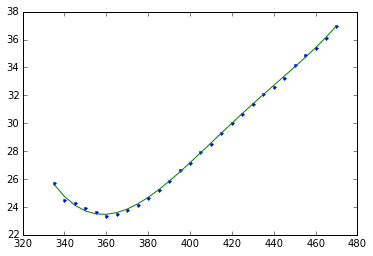

In [37]:
    import graphlab
    import numpy as np
    import matplotlib.pyplot as plt
    %matplotlib inline

    # 1) we input the data we want to analyze

    cornstrikes = graphlab.SArray([335., 340., 345., 350., 355., 360., 365., 370., 375., 380., 385., 390., 395., 400., 405.,
                                   410., 415., 420., 425., 430., 435., 440., 445., 450., 455., 460., 465., 470])
    #print len(cornstrikes)

    cornIVjune = graphlab.SArray([25.69164207, 24.46192391, 24.25650175, 23.89051272, 23.65002889, 23.3349033, 23.49452984, 
                                  23.80157827, 24.10747942, 24.65181255, 25.24230355, 25.88610025, 26.64076852, 27.17659603,
                                  27.94453293, 28.48655824, 29.29825713, 30.01127413, 30.67409426, 31.35183949, 32.11284635,
                                  32.57426954, 33.2112623, 34.14200111, 34.8902043, 35.41158883, 36.08042703, 36.98050433,])
    #print len(cornIVjune)
    #
    #
    # 2) define a function for creation of polynomial features that we use later on in the polynomial regression function
    def print_coefficients(model):    
        # Get the degree of the polynomial
        deg = len(model.coefficients['value'])-1

        # Get learned parameters as a list
        w = list(model.coefficients['value'])

        # Numpy has a nifty function to print out polynomials in a pretty way
        # (We'll use it, but it needs the parameters in the reverse order)
        print 'Learned polynomial for degree ' + str(deg) + ':'
        w.reverse()
        print np.poly1d(w)

    #print_coefficients(trainingIV_model)

    def polynomial_sframe(feature, degree):
        # assume that degree >= 1
        # initialize the SFrame:
        poly_sframe = graphlab.SFrame()
        # and set poly_sframe['power_1'] equal to the passed feature
        poly_sframe['power_1']=feature
        # first check if degree > 1
        if degree > 1:
            # then loop over the remaining degrees:
            # range usually starts at 0 and stops at the endpoint-1. We want it to start at 2 and stop at degree
            for power in range(2, degree+1): 
                # first we'll give the column a name:
                name = 'power_' + str(power)
                # then assign poly_sframe[name] to the appropriate power of feature
                poly_sframe[name]=feature.apply(lambda x: x**power)
        return poly_sframe

    # 5) define a residual sum of squares function in order to asses the error magnitude of our regression models

    def get_residual_sum_of_squares(training_model, validation, validation_IV):
            valid_predict = training_model.predict(validation)
            #print valid_predict
            #print validation_IV
            valid_residuals = valid_predict-validation['iv']
            valid_residuals_sq=valid_residuals*valid_residuals
            RSS=valid_residuals_sq.sum()
            return(RSS)

    # 6) define a function for cross-validation of our model on the train&validation partition

    def k_fold_cross_validation(k, l2_penalty, data, output_name, features_list):
        n = len(data)
        validation_RSS=[None]*(k-1) #create an empty array in order to assign loop outputs to its cells
        for i in range(0,k-1):
            start = (n*i)/k
            end = (n*(i+1))/k-1
            validation_set = data[start:end+1]
            part_1 = train_valid_shuffled[0:start]
            part_2 = train_valid_shuffled[end+1:n]
            training_set = part_1.append(part_2)
            training_model2 = graphlab.linear_regression.create(training_set, target = output_name, features = features_list, 
                                                              l2_penalty = l2_penalty, validation_set = None, verbose = False)
            validation_RSS[i] = get_residual_sum_of_squares(training_model2, validation_set, output_name)
        #print validation_RSS
        global mean_val_RSS
        mean_val_RSS=np.hstack(validation_RSS).mean() #stack the loop outputs, presented as list in order to calculate mean
        
    # 6) loop our model through all the degrees of polynomial regression that we want to test using our cross validation method 
dct = {}
deg = 8
global RSStest
RSStest = range(deg)

    for degree in range(1, deg+1):
        testpolyframe = polynomial_sframe(cornstrikes, degree)
        #print testpolyframe
        test_poly_features = testpolyframe.column_names()
        #print test_poly_features
        testpolyframe['iv']=cornIVjune
        #print testpolyframe
        (train_valid, test) = testpolyframe.random_split(.8, seed=1)
        train_valid_shuffled = graphlab.toolkits.cross_validation.shuffle(train_valid, random_seed=1)
        #print train_valid_shuffled
        trainingIV_model = graphlab.linear_regression.create(train_valid_shuffled, target = 'iv', features = test_poly_features,
                                                            validation_set = None, verbose = False)
        k_fold_cross_validation(len(train_valid_shuffled), 0, train_valid_shuffled, 'iv', test_poly_features)

        RSSall = get_residual_sum_of_squares(trainingIV_model, testpolyframe, 'iv')
        global finaloutput
        RSStest[degree-1] = get_residual_sum_of_squares(trainingIV_model, test, 'iv')
        dct[degree] = RSStest[degree-1]
        finaloutput = [degree, mean_val_RSS, RSStest, RSSall]
        #print finaloutput
        #print RSStest
#print RSStest
#print dct
bestdegree = None
minRSStest = None

for name,count in dct.items():
        if minRSStest is None or count < minRSStest:
            minRSStest = count
            bestdegree = name
        
print bestdegree, minRSStest

testpolyframe = polynomial_sframe(cornstrikes, bestdegree)
#print testpolyframe
test_poly_features = testpolyframe.column_names()
#print test_poly_features
testpolyframe['iv']=cornIVjune
#print testpolyframe
trainingIV_model = graphlab.linear_regression.create(testpolyframe, target = 'iv', features = test_poly_features, l2_penalty = 1e-25,
                                                    validation_set = None, verbose = False)
plt.plot(testpolyframe['power_1'], testpolyframe['iv'], '.',
        testpolyframe['power_1'], trainingIV_model.predict(testpolyframe), '-',)
#print trainingIV_model.predict(testpolyframe)
#print_coefficients(trainingIV_model)
#errors = trainingIV_model.predict(testpolyframe)-cornIVjune
#print errors.max()
#print errors.mean()

+---------+----------+------------+---------------+-------------+
| power_1 | power_2  |  power_3   |    power_4    |      iv     |
+---------+----------+------------+---------------+-------------+
|  335.0  | 112225.0 | 37595375.0 | 12594450625.0 | 25.69164207 |
|  340.0  | 115600.0 | 39304000.0 | 13363360000.0 | 24.46192391 |
|  345.0  | 119025.0 | 41063625.0 | 14166950625.0 | 24.25650175 |
|  350.0  | 122500.0 | 42875000.0 | 15006250000.0 | 23.89051272 |
|  355.0  | 126025.0 | 44738875.0 | 15882300625.0 | 23.65002889 |
|  360.0  | 129600.0 | 46656000.0 | 16796160000.0 |  23.3349033 |
|  365.0  | 133225.0 | 48627125.0 | 17748900625.0 | 23.49452984 |
|  370.0  | 136900.0 | 50653000.0 | 18741610000.0 | 23.80157827 |
|  375.0  | 140625.0 | 52734375.0 | 19775390625.0 | 24.10747942 |
|  380.0  | 144400.0 | 54872000.0 | 20851360000.0 | 24.65181255 |
+---------+----------+------------+---------------+-------------+
[28 rows x 5 columns]
Note: Only the head of the SFrame is printed.
You can 

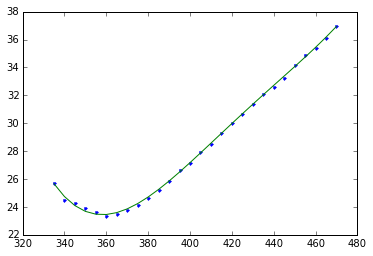

In [38]:
testpolyframe = polynomial_sframe(cornstrikes, 4)
    #print testpolyframe
test_poly_features = testpolyframe.column_names()
    #print test_poly_features
testpolyframe['iv']=cornIVjune

print testpolyframe

trainingIV_model = graphlab.linear_regression.create(testpolyframe, target = 'iv', features = test_poly_features, l2_penalty = 1e-25,
                                                    validation_set = None, verbose = False)
plt.plot(testpolyframe['power_1'], testpolyframe['iv'], '.',
        testpolyframe['power_1'], trainingIV_model.predict(testpolyframe), '-',)
print trainingIV_model.predict(testpolyframe)


print_coefficients(trainingIV_model)

errors = trainingIV_model.predict(testpolyframe)-cornIVjune
print errors.max()
print errors.mean()

5 3.04762138228


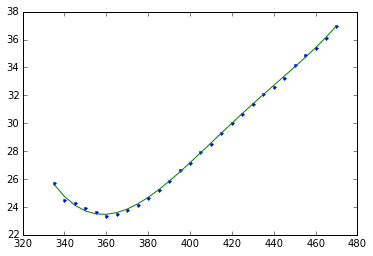

In [39]:
import graphlab
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 1) we input the data we want to analyze

cornstrikes = graphlab.SArray([335., 340., 345., 350., 355., 360., 365., 370., 375., 380., 385., 390., 395., 400., 405.,
							   410., 415., 420., 425., 430., 435., 440., 445., 450., 455., 460., 465., 470])
#print len(cornstrikes)

cornIVjune = graphlab.SArray([25.69164207, 24.46192391, 24.25650175, 23.89051272, 23.65002889, 23.3349033, 23.49452984, 
							  23.80157827, 24.10747942, 24.65181255, 25.24230355, 25.88610025, 26.64076852, 27.17659603,
							  27.94453293, 28.48655824, 29.29825713, 30.01127413, 30.67409426, 31.35183949, 32.11284635,
							  32.57426954, 33.2112623, 34.14200111, 34.8902043, 35.41158883, 36.08042703, 36.98050433,])
#print len(cornIVjune)
#
#
# 2) define a function for creation of polynomial features that we use later on in the polynomial regression function
def print_coefficients(model):    
	# Get the degree of the polynomial
	deg = len(model.coefficients['value'])-1

	# Get learned parameters as a list
	w = list(model.coefficients['value'])

	# Numpy has a nifty function to print out polynomials in a pretty way
	# (We'll use it, but it needs the parameters in the reverse order)
	print 'Learned polynomial for degree ' + str(deg) + ':'
	w.reverse()
	print np.poly1d(w)

#print_coefficients(trainingIV_model)

def polynomial_sframe(feature, degree):
	# assume that degree >= 1
	# initialize the SFrame:
	poly_sframe = graphlab.SFrame()
	# and set poly_sframe['power_1'] equal to the passed feature
	poly_sframe['power_1']=feature
	# first check if degree > 1
	if degree > 1:
		# then loop over the remaining degrees:
		# range usually starts at 0 and stops at the endpoint-1. We want it to start at 2 and stop at degree
		for power in range(2, degree+1): 
			# first we'll give the column a name:
			name = 'power_' + str(power)
			# then assign poly_sframe[name] to the appropriate power of feature
			poly_sframe[name]=feature.apply(lambda x: x**power)
	return poly_sframe

# 5) define a residual sum of squares function in order to asses the error magnitude of our regression models

def get_residual_sum_of_squares(training_model, validation, validation_IV):
		valid_predict = training_model.predict(validation)
		#print valid_predict
		#print validation_IV
		valid_residuals = valid_predict-validation['iv']
		valid_residuals_sq=valid_residuals*valid_residuals
		RSS=valid_residuals_sq.sum()
		return(RSS)

# 6) define a function for cross-validation of our model on the train&validation partition

def k_fold_cross_validation(k, l2_penalty, data, output_name, features_list):
	n = len(data)
	validation_RSS=[None]*(k-1) #create an empty array in order to assign loop outputs to its cells
	for i in range(0,k-1):
		start = (n*i)/k
		end = (n*(i+1))/k-1
		validation_set = data[start:end+1]
		part_1 = train_valid_shuffled[0:start]
		part_2 = train_valid_shuffled[end+1:n]
		training_set = part_1.append(part_2)
		training_model2 = graphlab.linear_regression.create(training_set, target = output_name, features = features_list, 
														  l2_penalty = l2_penalty, validation_set = None, verbose = False)
		validation_RSS[i] = get_residual_sum_of_squares(training_model2, validation_set, output_name)
	#print validation_RSS
	global mean_val_RSS
	mean_val_RSS=np.hstack(validation_RSS).mean() #stack the loop outputs, presented as list in order to calculate mean
	
# 6) loop our model through all the degrees of polynomial regression that we want to test using our cross validation method 
dct = {}
deg = 8
global RSStest
RSStest = range(deg)

for degree in range(1, deg+1):
	testpolyframe = polynomial_sframe(cornstrikes, degree)
	#print testpolyframe
	test_poly_features = testpolyframe.column_names()
	#print test_poly_features
	testpolyframe['iv']=cornIVjune
	#print testpolyframe
	(train_valid, test) = testpolyframe.random_split(.8, seed=1)
	train_valid_shuffled = graphlab.toolkits.cross_validation.shuffle(train_valid, random_seed=1)
	#print train_valid_shuffled
	trainingIV_model = graphlab.linear_regression.create(train_valid_shuffled, target = 'iv', features = test_poly_features,
														validation_set = None, verbose = False)
	k_fold_cross_validation(len(train_valid_shuffled), 0, train_valid_shuffled, 'iv', test_poly_features)

	RSSall = get_residual_sum_of_squares(trainingIV_model, testpolyframe, 'iv')
	global finaloutput
	RSStest[degree-1] = get_residual_sum_of_squares(trainingIV_model, test, 'iv')
	dct[degree] = RSStest[degree-1]
	finaloutput = [degree, mean_val_RSS, RSStest, RSSall]
	#print finaloutput
	#print RSStest
#print RSStest
#print dct
bestdegree = None
minRSStest = None

for name,count in dct.items():
        if minRSStest is None or count < minRSStest:
            minRSStest = count
            bestdegree = name
        
print bestdegree, minRSStest

testpolyframe = polynomial_sframe(cornstrikes, bestdegree)
#print testpolyframe
test_poly_features = testpolyframe.column_names()
#print test_poly_features
testpolyframe['iv']=cornIVjune
#print testpolyframe
trainingIV_model = graphlab.linear_regression.create(testpolyframe, target = 'iv', features = test_poly_features, l2_penalty = 1e-25,
                                                    validation_set = None, verbose = False)
plt.plot(testpolyframe['power_1'], testpolyframe['iv'], '.',
        testpolyframe['power_1'], trainingIV_model.predict(testpolyframe), '-',)
#print trainingIV_model.predict(testpolyframe)
#print_coefficients(trainingIV_model)
#errors = trainingIV_model.predict(testpolyframe)-cornIVjune
#print errors.max()
#print errors.mean()